In [1]:
%reset -f

In [12]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [13]:
# load x, y

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# flatten x
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

In [14]:
class fLDA():
    def __init__(self,D_new):
        self.D_new = D_new
        self.W = None
    
    def fit(self, X, y,):
        classes = np.unique(y)
        n_features = X.shape[1]
        
        # mean of each class
        mean_vectors = []
        for cl in classes:
            mean_vectors.append(np.mean(X[y==cl], axis=0).reshape(-1,1))
        
        # within class scatter matrix
        S_W = np.zeros((n_features, n_features))
        for cl, mv in zip(classes, mean_vectors):
            class_sc_mat = np.cov((X[y==cl]-mv.T).T)
            S_W += class_sc_mat
        
        # between class scatter matrix
        big_mean = np.mean(X, axis=0).reshape(-1,1)
        S_B = np.zeros((n_features, n_features))
        for i, mv in enumerate(mean_vectors):
            n = X[y==classes[i]].shape[0]
            S_B += n * (mv - big_mean).dot((mv - big_mean).T)

        # eigenvalues and eigenvectors
        S_W_inv = np.linalg.pinv(S_W)
        eig_vals, eig_vecs = np.linalg.eig(S_W_inv.dot(S_B))

        # sort eigenvalues in descending order
        sorted_ind = np.argsort(eig_vals)[::-1]
        eig_vals = eig_vals[sorted_ind]
        eig_vecs = eig_vecs[:,sorted_ind]

        # select top D' eigenvectors
        self.W = np.real(eig_vecs[:,:self.D_new])

        # Assume gaussian distribution
        # calculate the probability, mean and cov of each class
        proj = self.project(X)
        self.prior = []
        self.mean = []
        self.cov = []
        for cl in classes:
            self.prior.append(np.sum(y==cl)/y.shape[0])
            self.mean.append(np.mean(proj[y==cl], axis=0))
            self.cov.append(np.cov((proj[y==cl]-self.mean[-1]).T))
    
    def project(self, X):
        return X.dot(self.W)
    
    def predict(self, X, n_classes = 10):
        proj = self.project(X)
        y_pred = np.zeros(X.shape[0])

        for i in range(X.shape[0]):
            prob = []
            for cl in range(n_classes):
                prob.append(self.prior[cl]*self.__multivariate_normal(proj[i], self.mean[cl], self.cov[cl]))
            y_pred[i] = np.argmax(prob)
        
        return y_pred

    def score(self, X, y):
        proj = self.project(X)
        classes = np.unique(y)
        y_pred = np.zeros(y.shape[0])

        for i in range(y.shape[0]):
            prob = []
            for cl in classes:
                prob.append(self.prior[cl]*self.__multivariate_normal(proj[i], self.mean[cl], self.cov[cl]))
            y_pred[i] = np.argmax(prob)
        
        return np.sum(y_pred==y)/y.shape[0]

    def __multivariate_normal(self, x, mean, cov):
        return np.exp(-0.5*(x-mean).T.dot(np.linalg.pinv(cov)).dot(x-mean))/(np.sqrt(np.linalg.det(cov))*(np.sqrt(2*np.pi)**x.shape[0]))
        

In [15]:
def fLDA_test(X, y, w):
    y_pred = np.sign(X.dot(w))
    y_pred[y_pred==-1] = 0
    y_pred = y_pred.reshape(-1,1)
    y = y.reshape(-1,1)
    acc = len(y[y==y_pred])/len(y)
    return acc


In [24]:
clf = fLDA(D_new=2)

In [25]:
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.5661

In [19]:
proj = clf.project(x_test)
predictions = clf.predict(x_test)

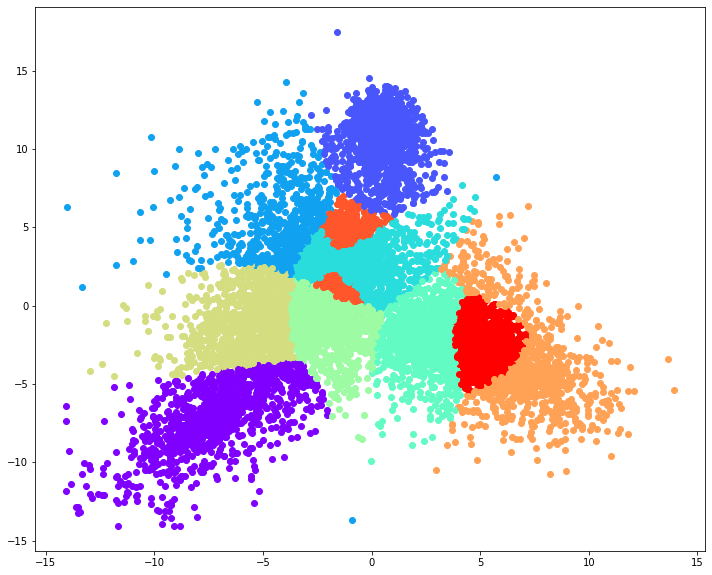

In [20]:
classes = list(np.unique(y_test))
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
plotlabels = {classes[c] : colors[c] for c in range(len(classes))}

plt.figure(figsize=(12,10))
for point,pred in zip(proj,predictions):
  plt.scatter(point[0],point[1],color=plotlabels[pred])
plt.show()

In [ ]:
a = np.random.multivariate_normal((1.5, 3), [[0.5, 0], [0, .05]], 30)
b = np.random.multivariate_normal((4, 1.5), [[0.5, 0], [0, .05]], 30)

In [ ]:
print(np.concatenate((a,b), axis=0).shape)
print(np.concatenate((np.zeros((30,1)), np.ones((30,1))), axis=0).shape)

(60, 2)
(60, 1)


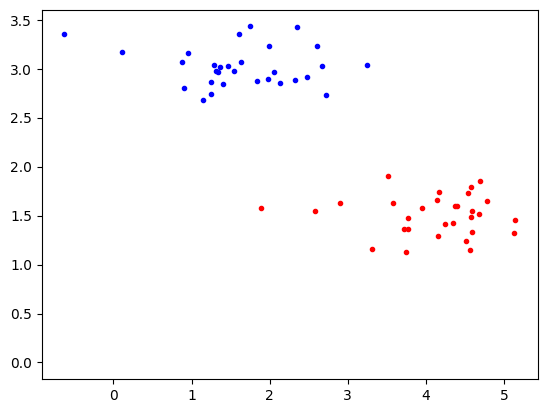

In [ ]:
# plot
plt.figure()
plt.plot(a[:,0], a[:,1], 'b.')
plt.plot(b[:,0], b[:,1], 'r.')
plt.plot([-w[0],w[0]], [-w[1],w[1]])
plt.show()

In [ ]:
X_in = np.concatenate((a,b), axis=0).squeeze()
y_in = np.concatenate((np.zeros((30,1)), np.ones((30,1))), axis=0).squeeze()

In [ ]:
mean1, mean0, w = fLDA_train(X_in, y_in)

(2, 2)


In [ ]:
proj = X_in.dot(w)

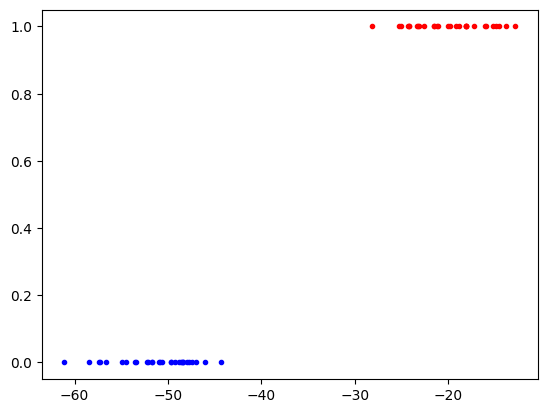

In [ ]:
plt.figure()
plt.plot(proj[y_in==0], np.zeros((30,)), 'b.')
plt.plot(proj[y_in==1], np.ones((30,)), 'r.')
plt.show()

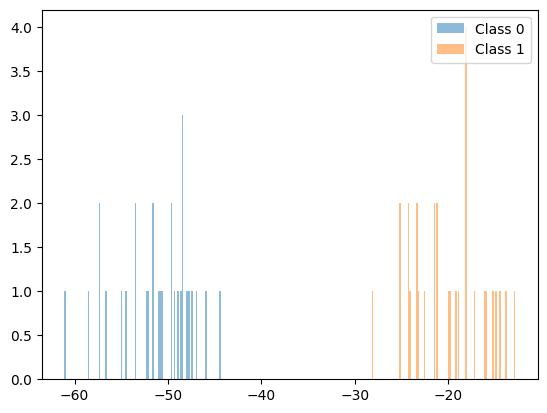

In [ ]:
# plot histogram
plt.figure()
plt.hist(proj[y_in==0], bins=100, alpha=0.5, label='Class 0')
plt.hist(proj[y_in==1], bins=100, alpha=0.5, label='Class 1')
plt.legend(loc='upper right')
plt.show()


In [39]:
print(proj.shape)

(60, 1)


In [40]:
print(w)

[[  3.31165975]
 [-11.7793063 ]]
